# Projet CENSE

In [1]:
import os
import numpy as np 
import numpy.linalg
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import IPython.display as ipd
from glob import glob
import librosa as lr

from sklearn.decomposition import PCA

## 1. Préprocessing

On commence par une petite phase de prétraitement sur les données.

Les données sont les matrices de MFCC des échantillons stockées dans la liste data. Elles sont regroupés par classes, c'est-à-dire que les 10 premiers éléments sont de la classe "bus", les 10 suivants de la classe "busytreet" et ainsi de suite. La liste labels contient les labels correspondant aux données et le dictionnaire dict_label est le dictionnaire faisant correspondre le numéro d'un label à son nom.

In [2]:
#set directory for source files 
data_dir = './scenes_stereo/'

audio_files = glob(data_dir + '*.wav')
print('file size:',len(audio_files))

file size: 100


In [3]:
data_list = glob(data_dir+"/*")
data = [] # Contiendra les mfcc de chaque échantillon

for name in ['bus','busystreet','office','openairmarket','park','quietstreet','restaurant','supermarket','tube','tubestation']:
    for k in range(1,10):
        data.append(lr.feature.mfcc(lr.load(data_dir+name + '0'+str(k)+'.wav')[0],n_mfcc = 40))
    data.append(lr.feature.mfcc(lr.load(data_dir+name + '10'+'.wav')[0],n_mfcc = 40))

In [4]:
data[0].shape

(40, 1292)

In [5]:
np.mean(data[0],axis=1).shape

(40,)

In [6]:
labels = [] # Labels des échantillons
for k in range(10):
    labels = labels+[k]*10
    
dict_labels = {'bus':0,'busystreet':1,'office':2,'openairmarket':3,'park':4,'quietstreet':5,'restaurant':6,'supermarket':7,'tube':8,'tubestation':9} 

## 2. Fenêtres de texture

On va ce coup-ci travailler sur des fenêtres de texture, ce qui signifie que l'on moyenne temporellement chaque matrice de MFCC dans des fenêtre de diverses taille.

In [7]:
def wind_texture(M,wsize):
    """Calcul les moyennes temporelles des fenêtres de textures dans une matrice de MFCC.

    M : Matrice de MFCC au format Quefrence x temps
    wsize : Nombre de trames retenues dans la fenêtre"""

    n,m = M.shape
    nwind = m//wsize
    
    W = np.zeros((n,nwind))
    
    for i in range (nwind):
        W[:,i] = np.mean(M[:,i*wsize:(i+1)*wsize],axis=1)
    
    return(W)

In [45]:
def dist(x,y,choix):
    """x et y sont des vecteurs."""
    if choix == "euclidean":
        return(np.linalg.norm(x-y))
    elif choix=="cosine":
        return(1-np.vdot(x,y)/np.linalg.norm(x)/np.linalg.norm(y))

In [48]:
def dist_wind(A,B,choix,wsize):
    """La distance entre A et B correspond à la distance entre les deux fenêtres les plus proches.
    
    A,B : Matrices de MFCC
    choix : distance euclidienne ou cosinus"""
    
    x = wind_texture(A,wsize)
    y = wind_texture(B,wsize)
    
    n,m = np.shape(x)
    distxy = np.zeros((m,1))
    
    for k in range(m):
        distxy[k] = dist(x[:,k],y[:,k],choix)

    return(distxy[np.where(distxy==min(distxy))[0][0]])

In [10]:
def p_at_k(mat_dist,K=5,labels=labels):
    p5 = np.zeros(100)
    for k in range(100):
        dist = mat_dist[k,:]
        distsort = np.argsort(np.ravel(dist))

        p5[k] = np.sum([labels[distsort[i]]==labels[k] for i in range(1,K+1)])/K
    return(np.mean(p5))

On calcule les précision au rang $k$ pour les différentes tailles de fenêtre, ainsi que pour la distance obtenue en sommant les résultats de chaque taille.

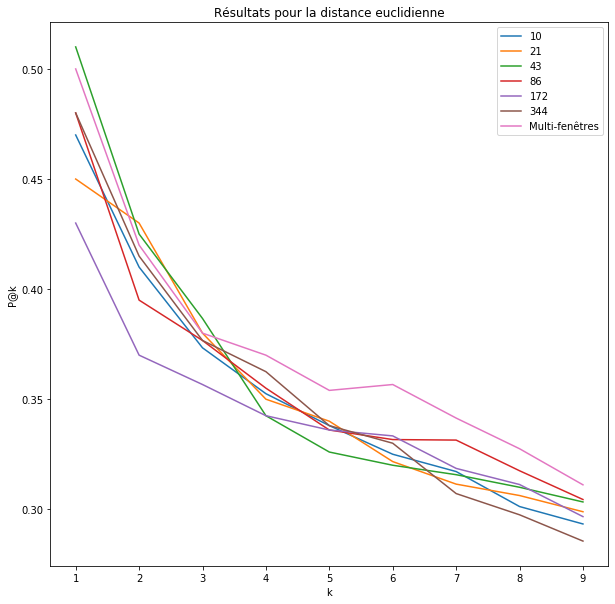

In [61]:
mat_dist = np.zeros((100,100))
seq_size = [10, 21, 43, 86, 172, 344] # 0.25s 0.5s 1s 2s 4s 8s
precision = np.zeros((len(seq_size),9))
num = 0


for windsize in seq_size:
    for i in range(100):
        for j in range(i,100):
            mat_dist[i,j] = dist_wind(data[i],data[j],'euclidean',windsize)
            mat_dist[j,i] = mat_dist[i,j]

    for k in range(1,10):
        precision[num,k-1] = p_at_k(mat_dist,k)
    num+=1
plt.figure(figsize=(10,10))    
for i in range(len(seq_size)):
    plt.plot(range(1,10),precision[i,:],label=seq_size[i])

mat_dist = np.zeros((100,100))
precision = np.zeros(9)

for i in range(100):
    for j in range(i,100):
        for windsize in seq_size:
            mat_dist[i,j] += dist_wind(data[i],data[j],'euclidean',windsize)
        mat_dist[j,i] = mat_dist[i,j]

for k in range(1,10):
    precision[k-1] = p_at_k(mat_dist,k)
plt.plot(range(1,10),precision,label = 'Multi-fenêtres')
plt.title('Résultats pour la distance euclidienne')
plt.xlabel('k')
plt.ylabel('P@k')
plt.legend()
plt.show()

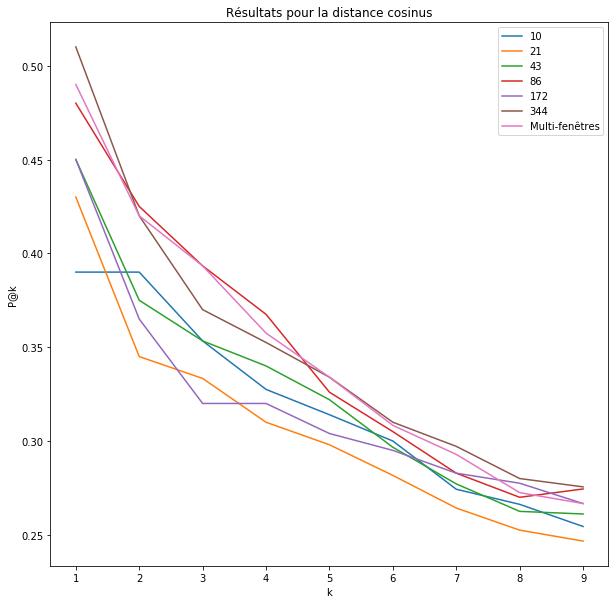

In [62]:
mat_dist = np.zeros((100,100))
seq_size = [10, 21, 43, 86, 172, 344] # 0.25s 0.5s 1s 2s 4s 8s
precision = np.zeros((len(seq_size),9))
num = 0


for windsize in seq_size:
    for i in range(100):
        for j in range(i,100):
            mat_dist[i,j] = dist_wind(data[i],data[j],'cosine',windsize)
            mat_dist[j,i] = mat_dist[i,j]

    for k in range(1,10):
        precision[num,k-1] = p_at_k(mat_dist,k)
    num+=1
plt.figure(figsize=(10,10))    
for i in range(len(seq_size)):
    plt.plot(range(1,10),precision[i,:],label=seq_size[i])

mat_dist = np.zeros((100,100))
precision = np.zeros(9)

for i in range(100):
    for j in range(i,100):
        for windsize in seq_size:
            mat_dist[i,j] += dist_wind(data[i],data[j],'cosine',windsize)
        mat_dist[j,i] = mat_dist[i,j]

for k in range(1,10):
    precision[k-1] = p_at_k(mat_dist,k)
plt.plot(range(1,10),precision,label = 'Multi-fenêtres')
plt.title('Résultats pour la distance cosinus')
plt.xlabel('k')
plt.ylabel('P@k')
plt.legend()
plt.show()

On voit que le fait de combiner plusieurs fenêtres donne des résultats légèrement meilleurs que la plupart du reste. Peut-être faut-il pondérer les fenêtre en favorisant celles qui donnaient de bons résultats, ou en réflechissant à une méthode d'optimisation.